# 作業: 使用 RNN 實作手寫數字辨識


## [作業目標]

*   使用 Pytorch 的 RNN
*   熟練建構 RNN 網路
*   RNN 也可以用在簡單的影像識別應用，準確度高達 90% 以上

### [動手做]
*   在 ImageRNN 類別裡面完成 RNN 物件 basic_rnn 的建立
*   在 ImageRNN 類別裡面完成 全連結層 FC 物件的建立

## [作業重點]

順利實作出手寫數字辨識的 RNN 模型
*   使用 torchvision 提供的手寫數字資料集
*   架構 ImageRNN 類別




### 載入會使用到的套件

In [1]:
import torch
from torch import nn
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

### 定義超參數

In [2]:
# 超參數 Hyper Parameters
EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 64
TIME_STEP = 28          # rnn time step / image height
INPUT_SIZE = 28         # rnn input size / image width
LR = 0.01               # learning rate
DOWNLOAD_MNIST = True   # set to True if haven't download the data

### 載入訓練資料
建立 train_loader 物件用來載入訓練資料


In [3]:
# 載入手寫數字資料集 Mnist digital dataset
train_data = dsets.MNIST(
    root='./data/mnist/',
    train=True,                         # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                        # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,            # download it if you don't have it
)

# plot one example
print(train_data.data.size())     # (60000, 28, 28)
print(train_data.targets.size())  # (60000)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([60000, 28, 28])
torch.Size([60000])


### 載入測試資料
建立 test_loader 物件用來載入訓練資料

In [4]:
# convert test data into Variable, pick 2000 samples to speed up testing
test_data = dsets.MNIST(root='./data/mnist/', train=False, transform=transforms.ToTensor())
test_x = test_data.data.type(torch.FloatTensor)[:2000]/255.   # shape (2000, 28, 28) value in range(0,1)
test_y = test_data.targets.numpy()[:2000]    # covert to numpy array

test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

### 把資料顯示出來看看

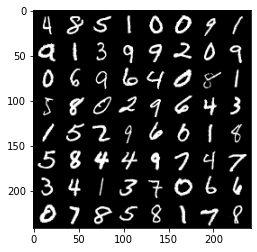

In [5]:
import numpy as np
# Exploring the dataset

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

### 根據資料集的特性，定義資料參數

In [6]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 5

### 架構 RNN 網路

In [7]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        # 作業: 請查看 pytorch 文件，選用最基本的 RNN 來當作模型
        self.basic_rnn = nn.RNN(n_inputs, n_neurons)
        
        # 作業: 定義一個全連結層
        self.FC = nn.Linear(n_neurons, n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()

        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

### 實作訓練程式

In [10]:
import torch.optim as optim

# use gpu if cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(train_loader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7323 | Train Accuracy: 76.08
Epoch:  1 | Loss: 0.3112 | Train Accuracy: 90.95
Epoch:  2 | Loss: 0.2336 | Train Accuracy: 93.38
Epoch:  3 | Loss: 0.1902 | Train Accuracy: 94.59
Epoch:  4 | Loss: 0.1664 | Train Accuracy: 95.33


### 實作測試程式

In [9]:
# Calculate test accuracy
test_acc = 0.0
for i, data in enumerate(test_loader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%(test_acc/i))

Test Accuracy: 95.20
